# Accumulated Local Effects for predicting house prices

In this example we will explain the behaviour of regression models on the California housing dataset. We will show how to calculate accumulated local effects (ALE) for determining the feature effects on a model and how these vary on different kinds of models (linear and non-linear models).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

2023-02-18 21:07:40.895423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch and prepare the dataset

Each row in the dataset represents a whole census block (the smallest geographical unit for which the US census publishes data), thus the feature values for each datapoint are averages within the block. For a complete description of the dataset please refer to the [scikit-learn documentation page](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

In [2]:
data = fetch_california_housing(as_frame=True)
feature_names = data.feature_names

In [18]:
data.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [19]:
X, y = data.data.to_numpy(), data.target.to_numpy()

Shuffle the data and define the train and test set:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
X_train

array([[   4.2143    ,   37.        ,    5.28823529, ...,    2.52941176,
          33.81      , -118.12      ],
       [   5.3468    ,   42.        ,    6.36432161, ...,    2.40452261,
          37.16      , -121.98      ],
       [   3.9191    ,   36.        ,    6.11006289, ...,    2.23584906,
          38.45      , -122.69      ],
       ...,
       [   2.9344    ,   36.        ,    3.98671727, ...,    3.33206831,
          34.03      , -118.38      ],
       [   5.7192    ,   15.        ,    6.39534884, ...,    3.17889088,
          37.58      , -121.96      ],
       [   2.5755    ,   52.        ,    3.40257649, ...,    2.10869565,
          37.77      , -122.42      ]])

## Fit and evaluate models

Fit and evaluate a linear regression model:

In [21]:
lr = LinearRegression()

In [22]:
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
mean_squared_error(y_test, lr.predict(X_test))

0.5411287478470682

Fit and evaluate a random forest model:

In [24]:
rf = RandomForestRegressor()

In [25]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [26]:
mean_squared_error(y_test, rf.predict(X_test))

0.2540371125189011

## Feature Effects: Motivation

Here we develop an intuition for calculating feature effects. We start by illustrating the calculation of feature effects for the linear regression model.

For our regression model, the conditional mean or the prediction function $\mathbb{E}(y\vert x)=f(x)$ is linear:

$$
f(x) = w_0 + w_1x_1 + \dots + w_kx_k.
$$

Because the model is additive and doesn't include feature interactions, we can read off individual feature effects immediately: the effect of any feature $x_i$ is just $w_ix_i$, so the effect is a linear function of $x_i$ and the sign of the coefficient $w_i$ determines whether the effect is positive or negative as $x_i$ changes.

Now suppose we don't know the true effect of the feature $x_i$ which is usually the case when using a more complex model. How might we approach the problem of estimating the effect? Let's focus on one feature - median income (`MedInc`). The following is a scatterplot of model predictions versus the feature:

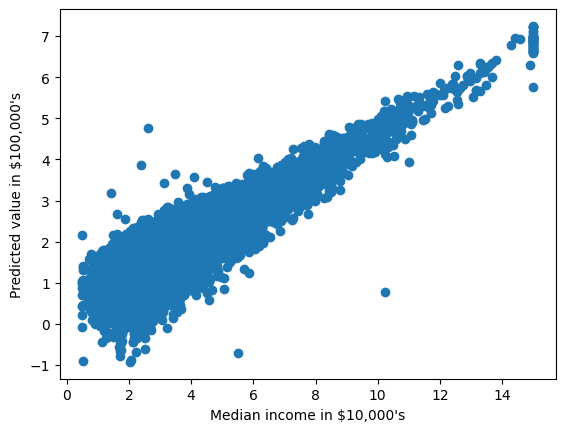

In [28]:
FEATURE = 'MedInc'
index = feature_names.index(FEATURE)

fig, ax = plt.subplots()
ax.scatter(X_train[:, index], lr.predict(X_train));

ax.set_xlabel('Median income in $10,000\'s');
ax.set_ylabel('Predicted value in $100,000\'s');

As we can see, there is a strong positive correlation as one might expect. However the feature effects for `MedInc` cannot be read off immediately because the prediction function includes the effects of all features not just `MedInc`. What we need is a procedure to block out the effects of all other features to uncover the true effect of `MedInc` only. This is exactly what the ALE approach does by averaging the differences of predictions across small intervals of the feature.

## Calculate Accumulated Local Effects (ALE)

Here we initialize the ALE object by passing it the predictor function which in this case is `lr.predict` and `rf.predict` method for respective models. We also pass in feature names and target name for easier interpretation of the resulting explanations.

In [31]:
lr_ale = ALE(lr.predict, feature_names=feature_names, target_names=['Value in $100,000\'s'])
rf_ale = ALE(rf.predict, feature_names=feature_names, target_names=['Value in $100,000\'s'])

We now call the `explain` method on the explainer objects which will compute the ALE's and return an `Explanation` object which is ready for inspection and plotting. Since ALE is a global explanation method it takes in a batch of data for which the model feature effects are computed, in this case we pass in the training set.

In [32]:
lr_exp = lr_ale.explain(X_train)
rf_exp = rf_ale.explain(X_train)

The resulting `Explanation` objects contain the ALE's for each feature under the `ale_values` attribute - this is a list of numpy arrays, one for each feature. The easiest way to interpret the ALE values is by plotting them against the feature values for which we provide a built-in function `plot_ale`. By calling the function without arguments, we will plot the effects of every feature, so in this case we will get 8 different subplots. To fit them all on the screen we pass in options for the figure size.

## ALE for the linear regression model

The ALE plots show the main effects of each feature on the prediction function.

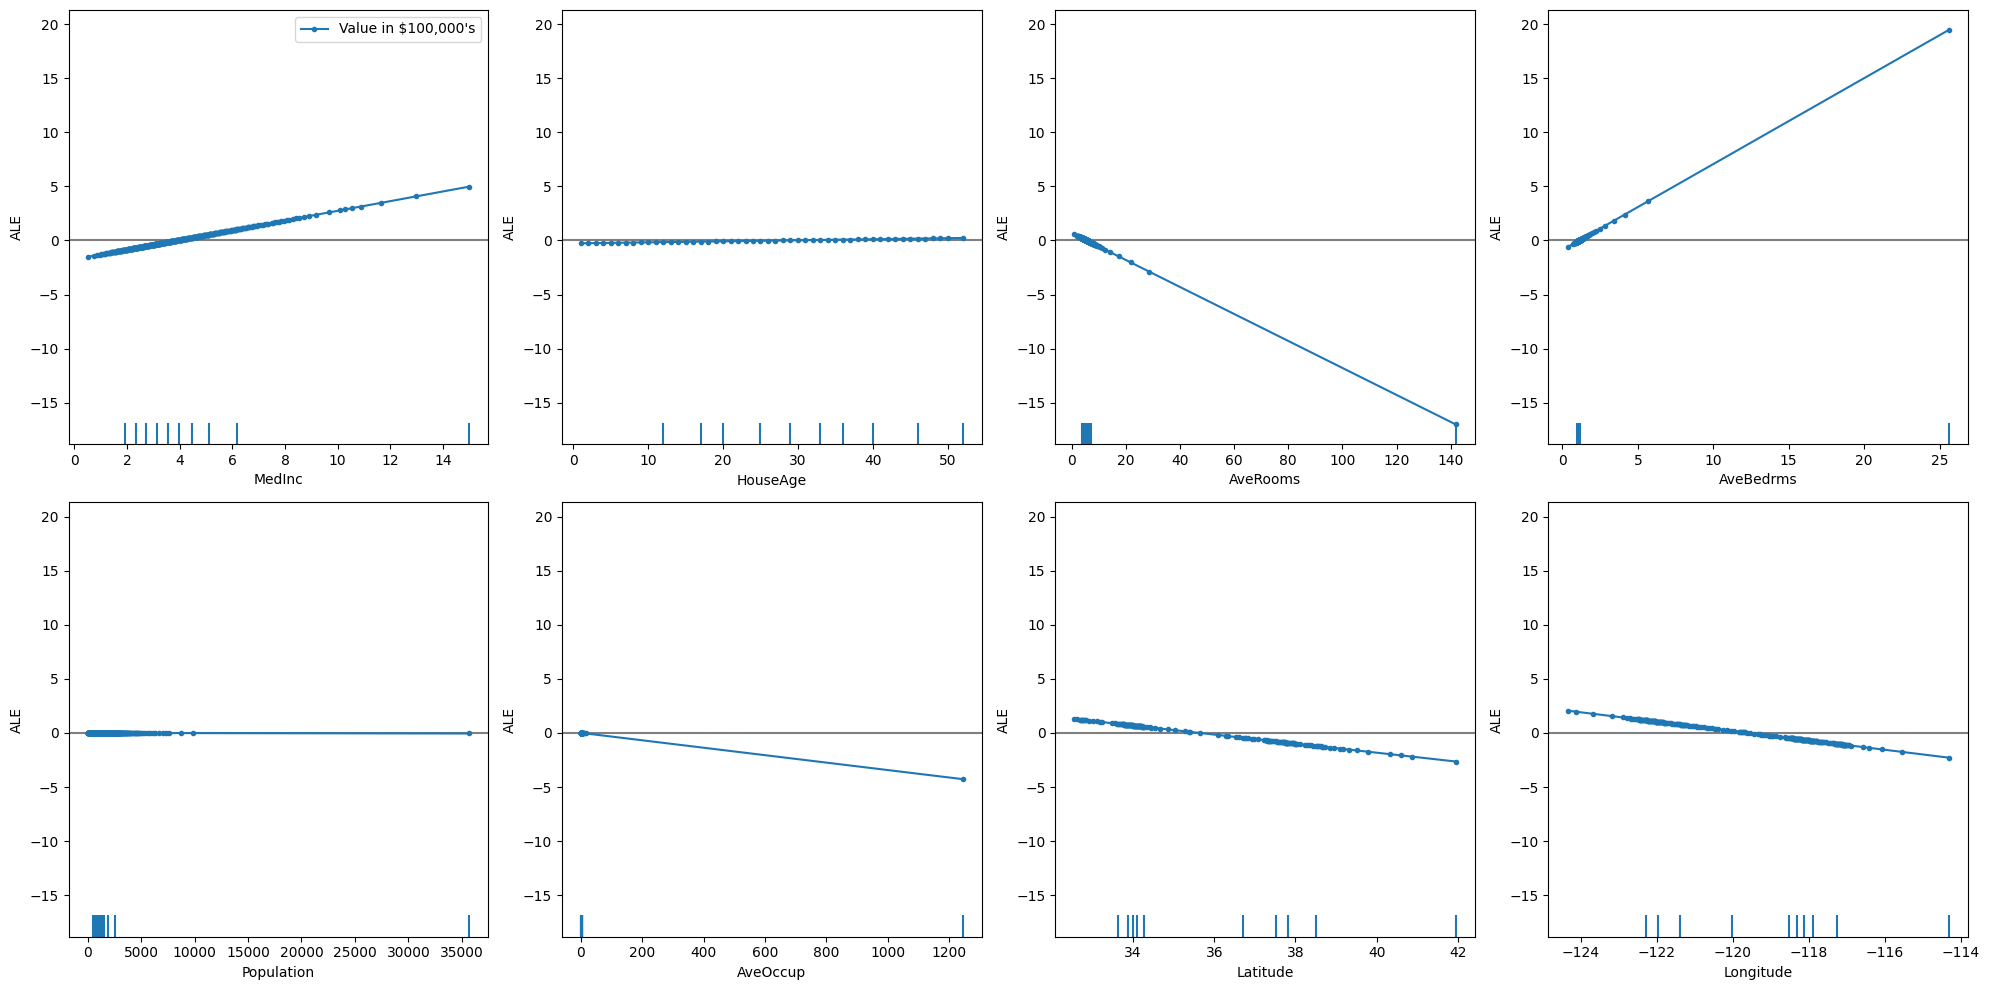

In [33]:
plot_ale(lr_exp, n_cols=4, fig_kw={'figwidth':20, 'figheight': 10});

As expected, the feature effects plots are linear because we used a linear model. The interpretation of the ALE plot is that, given a feature value, the ALE value corresponding to that feature value is the difference to the mean effect of that feature. Put differently, the ALE value is the relative feature effect on the prediction at that feature value.

### Effect of the median income

Let's look at the ALE plot for the feature `MedInc` (median income) in more detail:

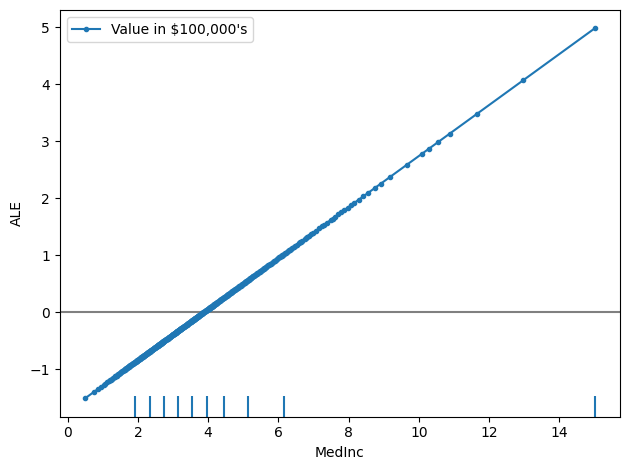

In [34]:
plot_ale(lr_exp, features=['MedInc']);

The ALE on the y-axes of the plot above is in the units of the prediction variable which, in this case, is the value of the house in \$100,000's.

The median income here is in units of \$10,000's.

The main interpretation of the ALE plot is qualitative—fixing the feature value and looking at the ALE plot as a function at that point, the tangent at that point (or the slope of linear interpolation between the closest bin endpoints) shows how sensitive the target prediction is with respect to small changes of the feature value. Since we have a linear regression model, the tangent/slope is the same across the whole feature range so the feature sensitivity is identical at any point in the feature range. We can calculate it by taking the slope of the linear interpolation between any two points of the ALE plot:



In [35]:
slopes = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(lr_exp.ale_values, lr_exp.feature_values)])
slope_med_inc = slopes[feature_names.index('MedInc')]
print(slope_med_inc)

0.44760006851694645


This value can be interpreted that, at any point in the feature range of `MedInc`, the effect of changing it by some amount $\delta$ will result in a change in the prediction by approximately $0.4476\cdot\delta$. In other words, at any point an additional median income of \$10,000 would result in an uplift of the predicted house value by ~44,760 dollars.

<div class="alert alert-info">
Note
    
This interpretation doesn't mean that for any single datapoint the effect will be the same uplift. Rather, the effect is true *on average* for datapoints close to the feature value of interest, i.e. in a bin of size $\delta$.

</div>

We can also say a few more quantitative things about this plot.
The ALE value for the point `MedInc=6 ($60,000)` is ~1 which has the interpretation that for areas with this median income the model predicts an up-lift of ~\$100,000 *with respect to the average effect of* `MedInc`. This is because the ALE plots are centered such that the average effect of the feature across the whole range of it is zero.

On the other hand, for neighbourhoods with `MedInc=4 ($40,000)`, the ALE value is ~0 which indicates that the effect of the feature at this point is the same as the average effect of the feature. For even lower values of `MedInc`, below \$40,000, the feature effect becomes less than the average effect, i.e. a smaller median income in the area brings the predicted house value down with respect to the average feature effect.

### Effect of the crime level

An additional feature of the ALE plot is that it shows feature deciles on the x-axis. This helps understand in which regions there is low data density so the ALE plot is interpolating. For example, for the `AveOccup` feature (average number of household members), there appears to be an outlier in the data at over ~1,200 which causes the plot to linearly interpolate over a large range where there is no data. Note that this can also be seen by the lack of markers on the plot within that large range.

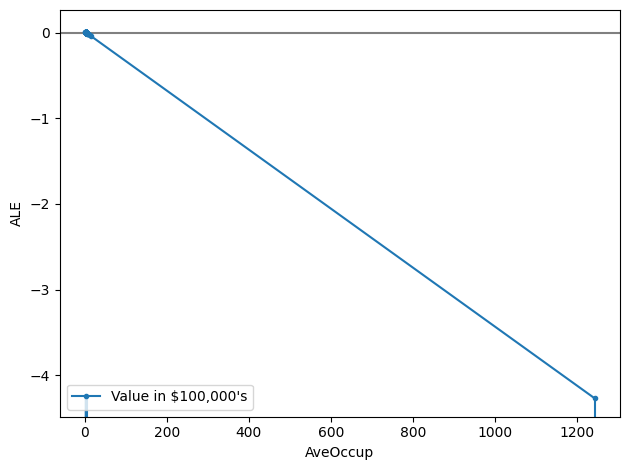

In [36]:
plot_ale(lr_exp, features=['AveOccup']);

For linear models this is not an issue as we know the effect is linear across the whole range of the feature, however for non-linear models linear interpolation in feature areas with no data could be unreliable. This is why the use of deciles can help assess in which areas of the feature space the estimated feature effects are more reliable.

### Linearity of ALE

It is no surprise that the ALE plots for the linear regression model are linear themselves—the feature effects are after all linear by definition. In fact, the slopes of the ALE lines are exactly the coefficients of the linear regression:

In [37]:
lr.coef_

array([ 4.47600069e-01,  9.56752596e-03, -1.24755956e-01,  7.94471254e-01,
       -1.43902596e-06, -3.44307993e-03, -4.18555257e-01, -4.33405135e-01])

In [38]:
slopes

array([ 4.47600069e-01,  9.56752596e-03, -1.24755956e-01,  7.94471254e-01,
       -1.43902596e-06, -3.44307993e-03, -4.18555257e-01, -4.33405135e-01])

In [39]:
np.allclose(lr.coef_, slopes)

True

Thus the slopes of the ALE plots for linear regression have exactly the same interpretation as the coefficients of the learnt model—global feature effects. In fact, we can calculate the ALE effect of linear regression analytically to show that the effect of feature $x_i$ is $\text{ALE}(x_i) = w_ix_i-w_i\mathbb{E}(x_i)$ which is the familiar effect $w_ix_i$ relative to the mean effect of the feature.

## ALE for the random forest model

Now let's look at the ALE plots for the non-linear random forest model:

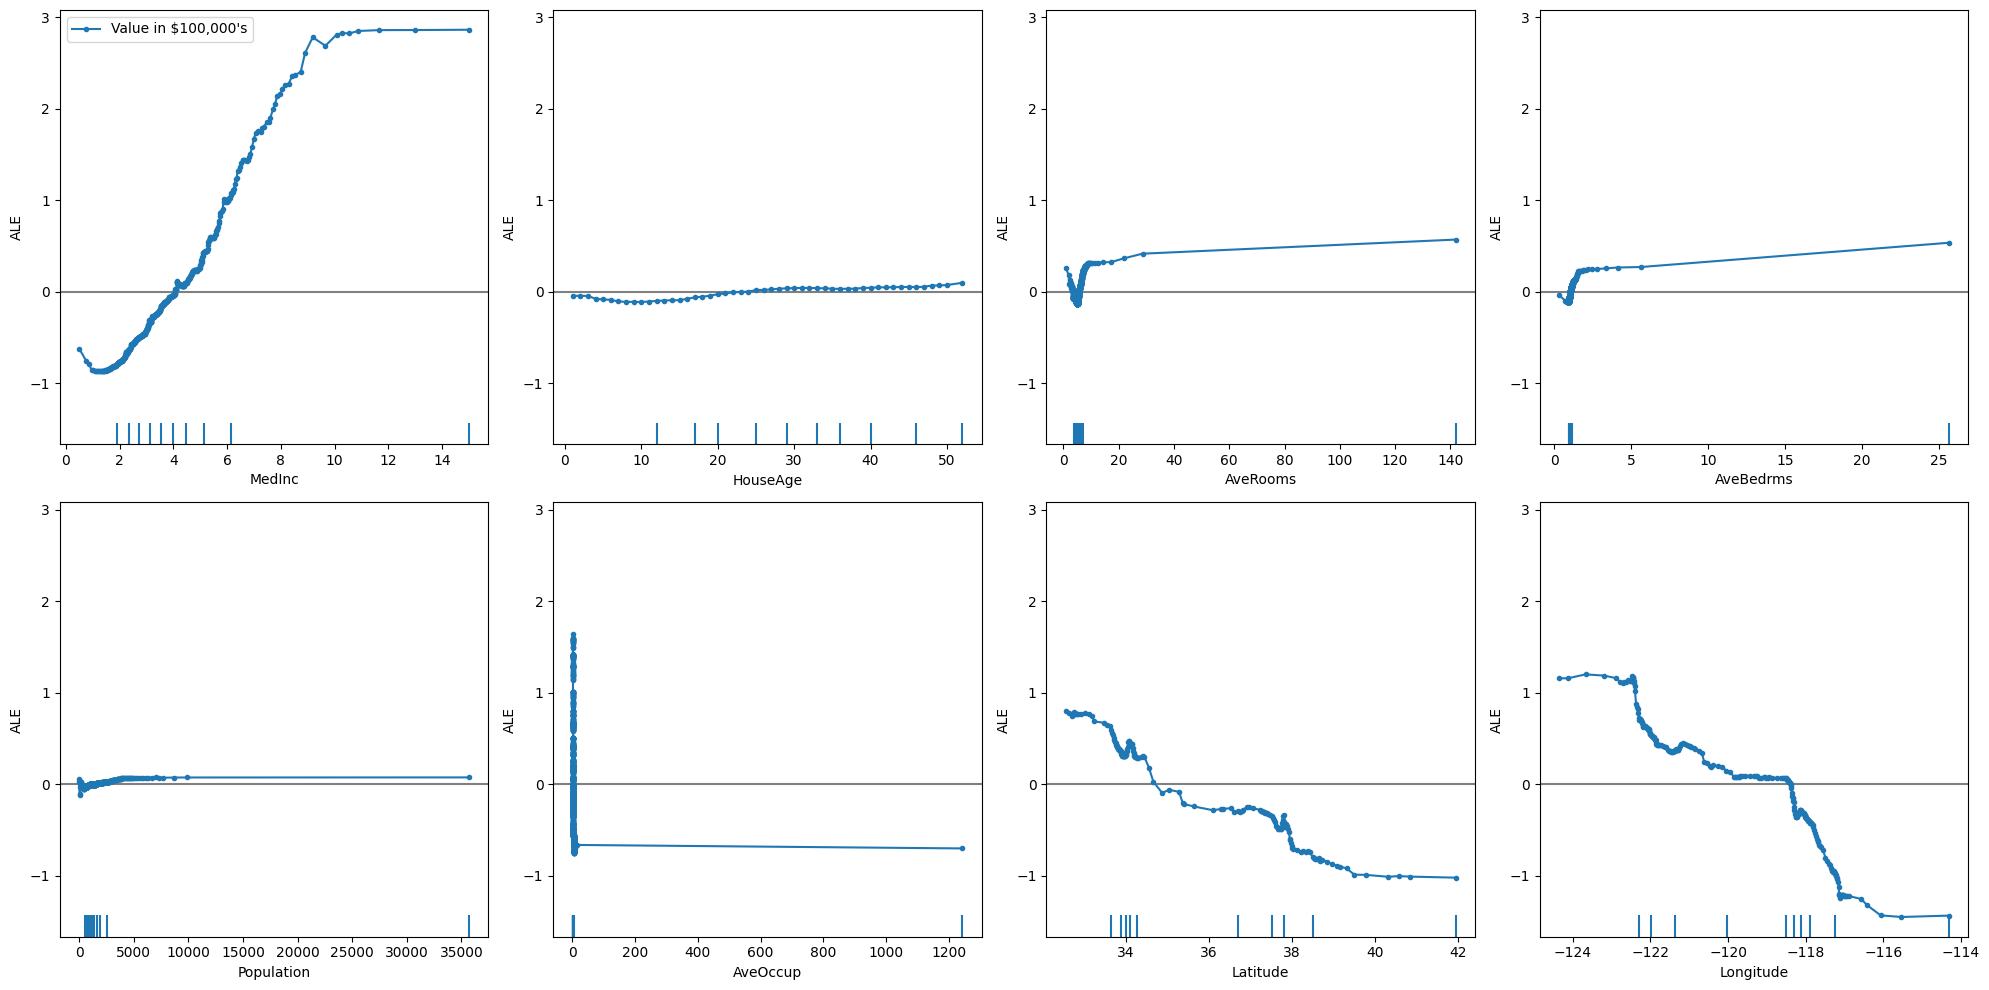

In [43]:
axes = plot_ale(rf_exp, n_cols=4, fig_kw={'figwidth':20, 'figheight': 10});

Because the model is no longer linear, the ALE plots are non-linear also and in some cases also non-monotonic. The interpretation of the plots is still the same—the ALE value at a point is the relative feature effect with respect to the mean feature effect, however the non-linear model used shows that the feature effects differ both in shape and magnitude when compared to the linear model.

From these plots, it seems that the feature `MedInc` (median income) has the biggest impact on the prediction. Checking the built-in feature importances of the random forest classifier confirms this:

In [44]:
feature_names[rf[1].feature_importances_.argmax()]

'MedInc'

Let's explore the feature `Latitude` and how its effects are different between the two models. To do this, we can pass in matplotlib `axes` objects for the `plot_ale` function to plot on:

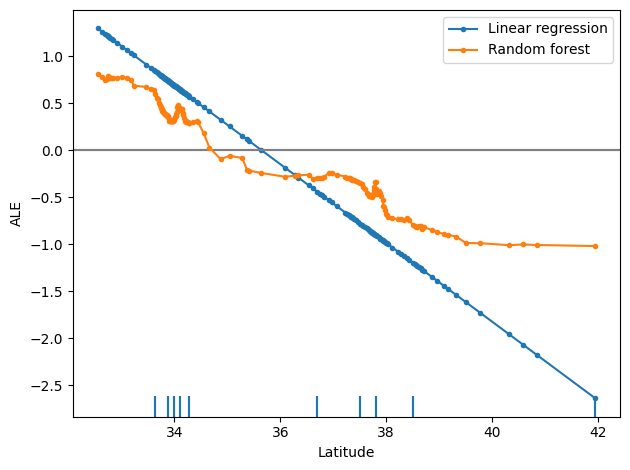

In [45]:
fig, ax = plt.subplots()
plot_ale(lr_exp, features=['Latitude'], ax=ax, line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, features=['Latitude'], ax=ax, line_kw={'label': 'Random forest'});

From this plot we can gain a couple of interesting insights:

 - Whilst for linear regression the feature effects are the same across the range of the values of `Latitude`, for a random forest model, because it's a more capable predictor, there are intervals of `Latitude` where different behaviour is observed
 - For both models the feature effects of `Latitude` are negatively correlated, i.e. for areas more South (lower latitude) the effects on house price predictions are positive. However, for the random forest, the ALE curve is sometimes piece-wise constant which tells us that there are regions where the effects are roughly the same for different latitudes (e.g. between latitudes 36 and 37)
 - In general, the ALE for a non-linear model doesn't have to be monotonic, although in this case there are only very small departures from monotonicity which may be due to artifacts from the grid-size used to calculate the ALE. It may be useful to experiment with different resolutions of the grid size

Comparing the ALE plots of multiple models on the same axis should be done with care. In general, we can only make qualitative comparisons of the plots between different intervals of the feature values as we have done here.

To compare multiple models and multiple features we can plot the ALE's on a common axis that is big enough to accommodate all features of interest:

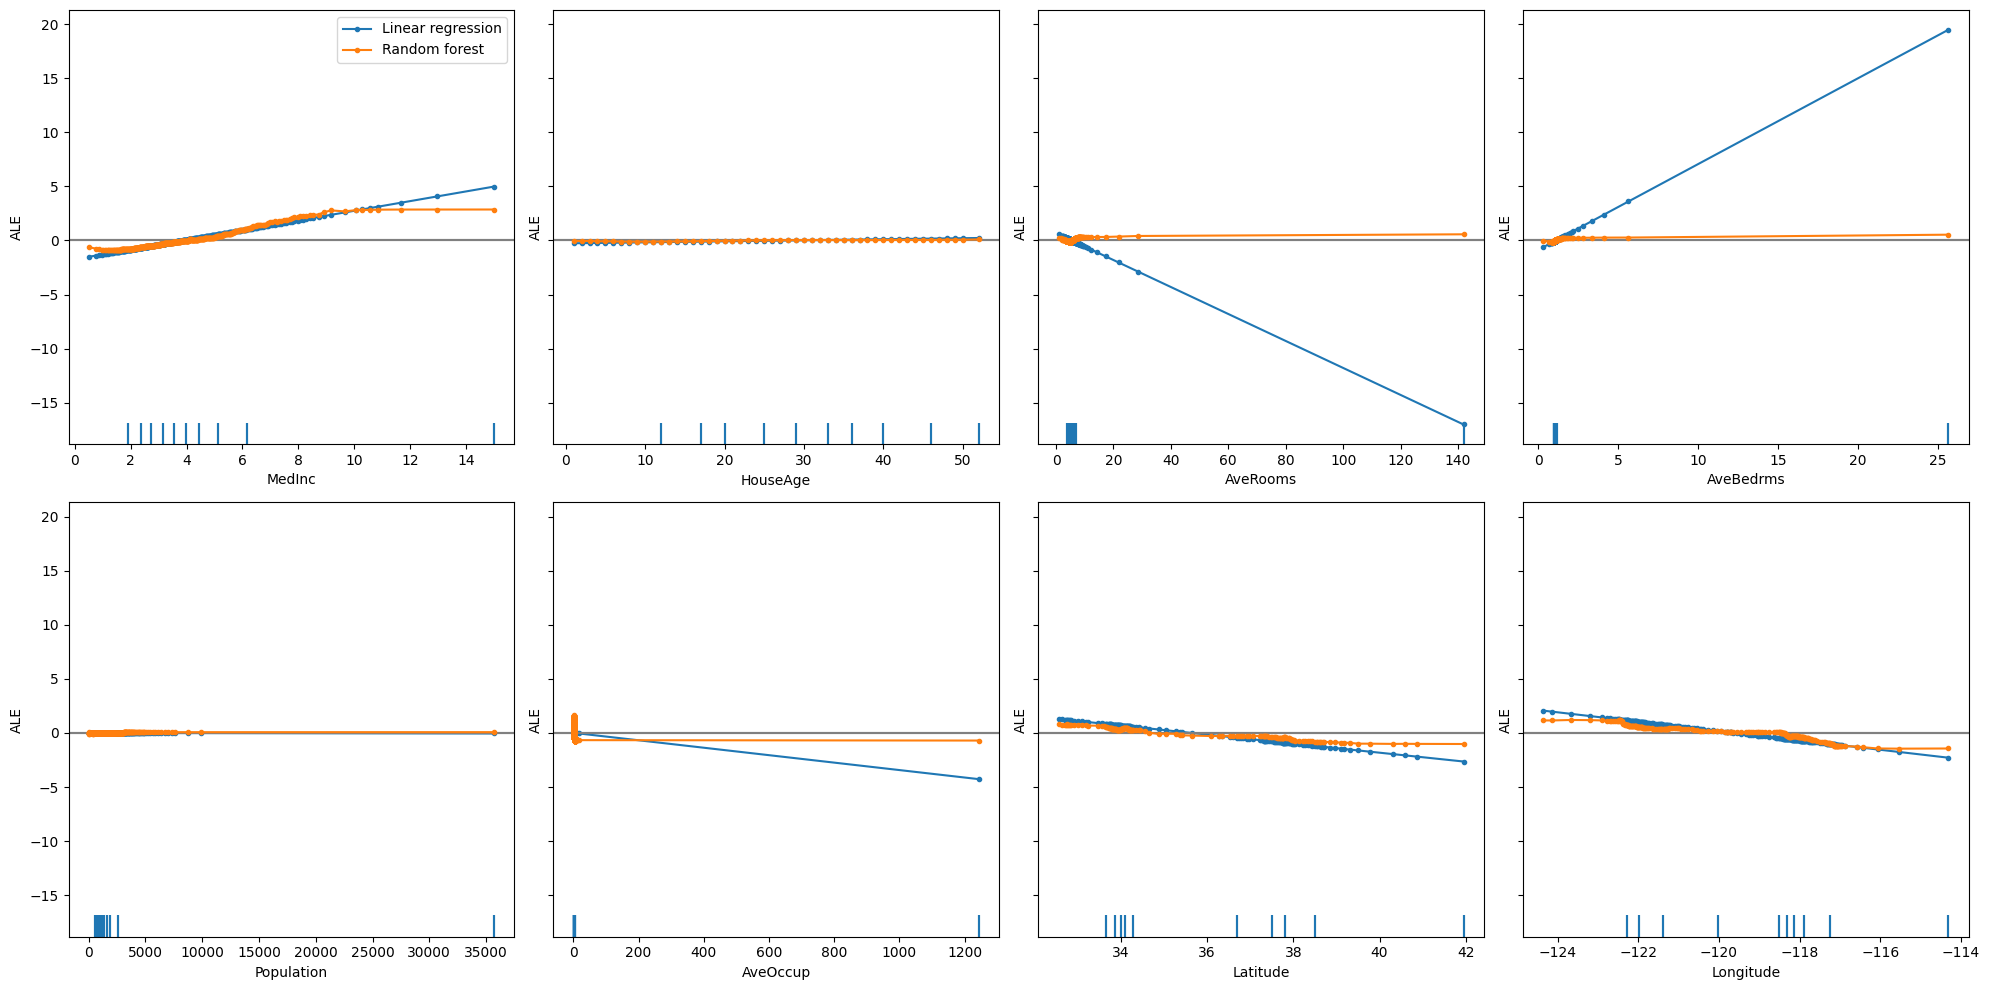

In [47]:
fig, ax = plt.subplots(2, 4, sharey='all');

plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':20, 'figheight': 10},
         line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random forest'});